In [27]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/home/ubuntu/varios/skforecast'

In [28]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

h2o
---
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman
/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (204, 2)
Train dates      : 1991-07-01 00:00:00 --- 2002-01-01 00:00:00  (n=127)
Validation dates : 2002-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=77)


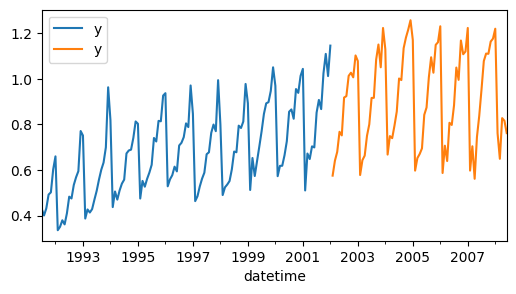

,y
datetime,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159
1991-10-01,0.492543


In [29]:
# Download data
# ==============================================================================
data = fetch_dataset(
    name="h2o", raw=True, kwargs_read_csv={"names": ["y", "datetime"], "header": 0}
)

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()

# Train-validation dates
# ==============================================================================
end_train = '2002-01-01 23:59:00'

print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}"
    f"  (n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.index.max()}"
    f"  (n={len(data.loc[end_train:])})"
)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='validation')
ax.legend()
plt.show()

display(data.head(4))

In [30]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 15 
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['y'],
                          steps                 = 10,
                          metric                = ['mean_squared_error', 'mean_absolute_error'],
                          initial_train_size    = len(data.loc[:end_train]),
                          fixed_train_size      = False,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = True,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True  
                      )
metric

Information of backtesting process
----------------------------------
Number of observations used for initial training: 127
Number of observations used for backtesting: 77
    Number of folds: 8
    Number skipped folds: 0 
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 7 observations.

Fold: 0
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00  (n=127)
    Validation: 2002-02-01 00:00:00 -- 2002-11-01 00:00:00  (n=10)
Fold: 1
    Training:   1991-07-01 00:00:00 -- 2002-11-01 00:00:00  (n=137)
    Validation: 2002-12-01 00:00:00 -- 2003-09-01 00:00:00  (n=10)
Fold: 2
    Training:   1991-07-01 00:00:00 -- 2003-09-01 00:00:00  (n=147)
    Validation: 2003-10-01 00:00:00 -- 2004-07-01 00:00:00  (n=10)
Fold: 3
    Training:   1991-07-01 00:00:00 -- 2004-07-01 00:00:00  (n=157)
    Validation: 2004-08-01 00:00:00 -- 2005-05-01 00:00:00  (n=10)
Fold: 4
    Training:   1991-07-01 00:00:00

  0%|          | 0/8 [00:00<?, ?it/s]

,mean_squared_error,mean_absolute_error
0,0.008185,0.064891


In [31]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import random_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster

In [32]:
# Download data
# ==============================================================================
data = fetch_dataset(
    name="h2o", raw=True, kwargs_read_csv={"names": ["y", "datetime"], "header": 0}
)

h2o
---
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman
/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (204, 2)


Train dates      : 1991-07-01 00:00:00 --- 2001-01-01 00:00:00  (n=115)
Validation dates : 2001-02-01 00:00:00 --- 2006-01-01 00:00:00  (n=60)
Test dates       : 2006-02-01 00:00:00 --- 2008-06-01 00:00:00 (n=29)


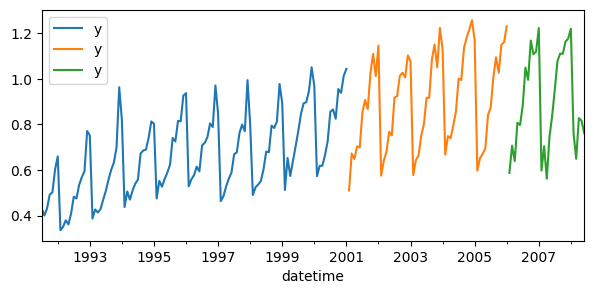

In [33]:
# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()

# Train-val-test dates
# ==============================================================================
end_train = '2001-01-01 23:59:00'
end_val = '2006-01-01 23:59:00'

print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}"
    f"  (n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}"
    f"  (n={len(data.loc[end_train:end_val])})"
)
print(
    f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}"
    f" (n={len(data.loc[end_val:])})"
)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:end_val].plot(ax=ax, label='validation')
data.loc[end_val:].plot(ax=ax, label='test')
ax.legend();

In [34]:
# Grid search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}

results = grid_search_forecaster(
              forecaster         = forecaster,
              y                  = data.loc[:end_val, 'y'],
              param_grid         = param_grid,
              lags_grid          = lags_grid,
              steps              = 12,
              refit              = False,
              metric             = 'mean_squared_error',
              initial_train_size = len(data.loc[:end_train]),
              fixed_train_size   = False,
              return_best        = True,
              n_jobs             = 'auto',
              verbose            = False,
              show_progress      = True
          )

results

Number of models compared: 18.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 15, 'n_estimators': 50}
  Backtesting metric: 0.015325449516605583



,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
4,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 15, 'n_estimators': 50}",0.015325,15,50
0,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.019538,5,50
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.021915,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 100}",0.023351,15,100
3,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.024818,10,100
5,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 15, 'n_estimators': 100}",0.028400,15,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.029157,5,50
13,"[1, 2, 3, 20]","[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.030666,5,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 50}",0.030762,15,50
1,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.030913,5,100
